In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hr-analytics-and-job-prediction/HR_comma_sep.csv


### Load dataset

In [2]:
# RUN THIS CELL TO IMPORT YOUR DATA. 

# Load dataset into a dataframe
### YOUR CODE HERE ###
df0 = pd.read_csv("/kaggle/input/hr-analytics-and-job-prediction/HR_comma_sep.csv")


# Display first few rows of the dataframe
### YOUR CODE HERE ###
df0.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


### Data exploration (EDA and data cleaning)

In [3]:
#Basic information about data
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [4]:
#Basic descriptive statistics about data
df0.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [5]:
df0.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')

Some of the columns have misspeling and for some reason few starts with a capital letter, for convinience we will rename those columns

In [6]:
#Renaming the columns
df0 = df0.rename(columns={'time_spend_company':'years_spend_company',
                    'Work_accident':'work_accident',
                   'Department':'department',
                    'average_montly_hours': 'average_monthly_hours'})
#checking new names
df0.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'years_spend_company', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

### Check missing values

In [7]:
df0.isna().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_monthly_hours    0
years_spend_company      0
work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

There is no missing data

## Check duplicates

In [8]:
df0.duplicated().sum()

3008

Wow, thats a lot, should inspect further

In [9]:
df0[df0.duplicated()].head(5)

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,years_spend_company,work_accident,left,promotion_last_5years,department,salary
396,0.46,0.57,2,139,3,0,1,0,sales,low
866,0.41,0.46,2,128,3,0,1,0,accounting,low
1317,0.37,0.51,2,127,3,0,1,0,sales,medium
1368,0.41,0.52,2,132,3,0,1,0,RandD,low
1461,0.42,0.53,2,142,3,0,1,0,sales,low


There is very little chance for appearing 2 same rows on random when there is so many variable, so i think we shoud drop duplicates

In [10]:
#drop duplicates and save clear data in a new variable
df = df0[~df0.duplicated()]
#check first few rows of new dataframe
df.head()


,satisfaction_level,last_evaluation,number_project,average_monthly_hours,years_spend_company,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


## Check outliers

<Axes: >

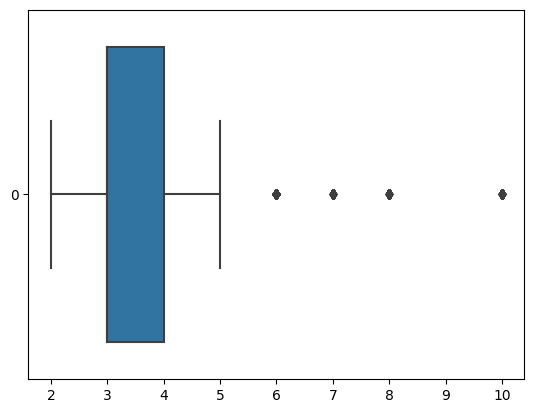

In [11]:
#it's easier to detect outliers by creating visualization

sns.boxplot(df['years_spend_company'], orient='h')

In [12]:
# Determine the number of rows containing outliers

percentile25 = df['years_spend_company'].quantile(0.25)
percentile75 = df['years_spend_company'].quantile(0.75)

#interquantile range:
iqr = percentile75 - percentile25
lower_limit = percentile25 - 1.5*iqr
upper_limit = percentile75 + 1.5*iqr

print('Lower limit: ', lower_limit)
print('Upper limit: ', upper_limit)

outliers = df[(df['years_spend_company'] < lower_limit)|(df['years_spend_company'] > upper_limit)]
print('Number of outliers: ', len(outliers))

Lower limit:  1.5
Upper limit:  5.5
Number of outliers:  824


Certain types of models are more sensitive to outliers than others. On the model building stage i should consider that dataset has some outliers

## Data Exploration

In [13]:
# numbers of people who left vs. stayed
left_v_stay = df['left'].value_counts()
print(left_v_stay)
#percentages of people who left vs. stayed
print('Stayed: ', round(left_v_stay[0]/len(df['left'])*100,3))
print('left: ', round(left_v_stay[1]/len(df['left'])*100,3))

left
0    10000
1     1991
Name: count, dtype: int64
Stayed:  83.396
left:  16.604


Dataset is unbalanced, approximately 16.6% employees in this dataset left. But it is not extremely unbalanced and we can model without any class rebalancing

### Data visualizations

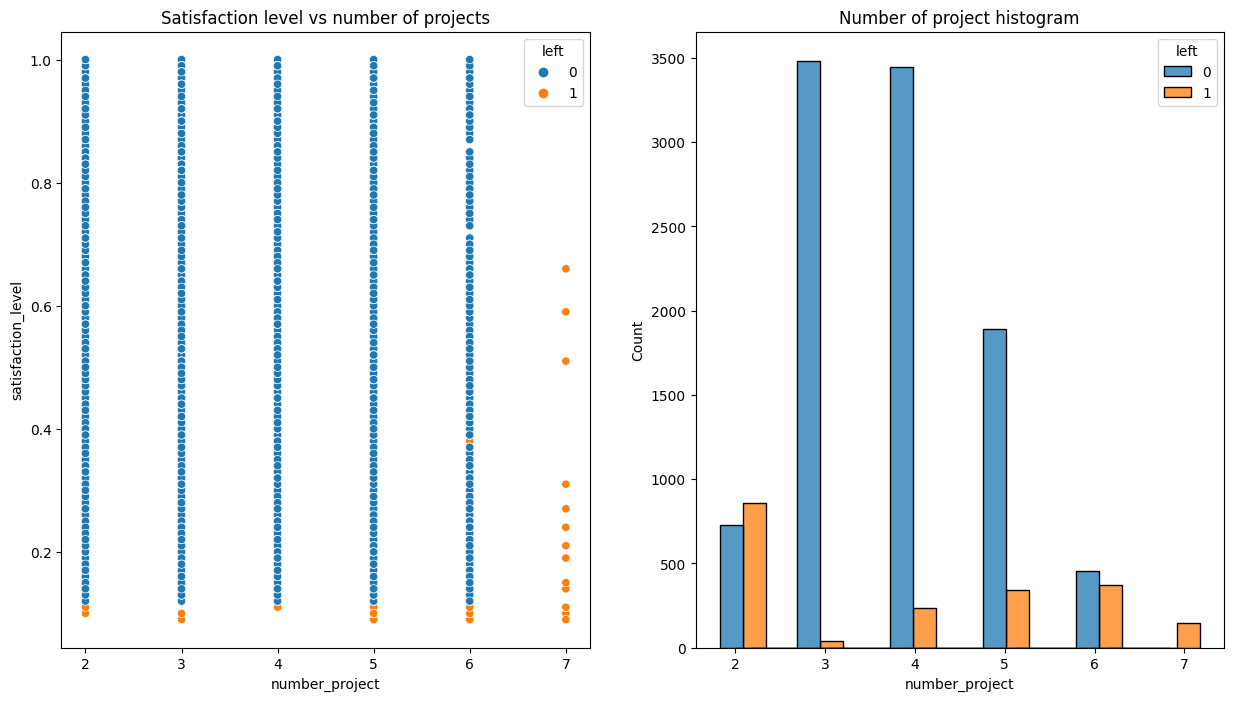

In [14]:
fig, ax = plt.subplots(1,2,figsize=(15,8))

sns.scatterplot(x=df['number_project'], y=df['satisfaction_level'], hue=df['left'], ax=ax[0])
ax[0].set_title('Satisfaction level vs number of projects')
sns.histplot(data=df, x='number_project', hue='left',multiple='dodge',shrink=3)
ax[1].set_title('Number of project histogram')
plt.show()

Interesting almost everyone who left has low satisfaction level and almost every one who had 7 project are left employees

People with 3 projects have the lowes number of leaving employees

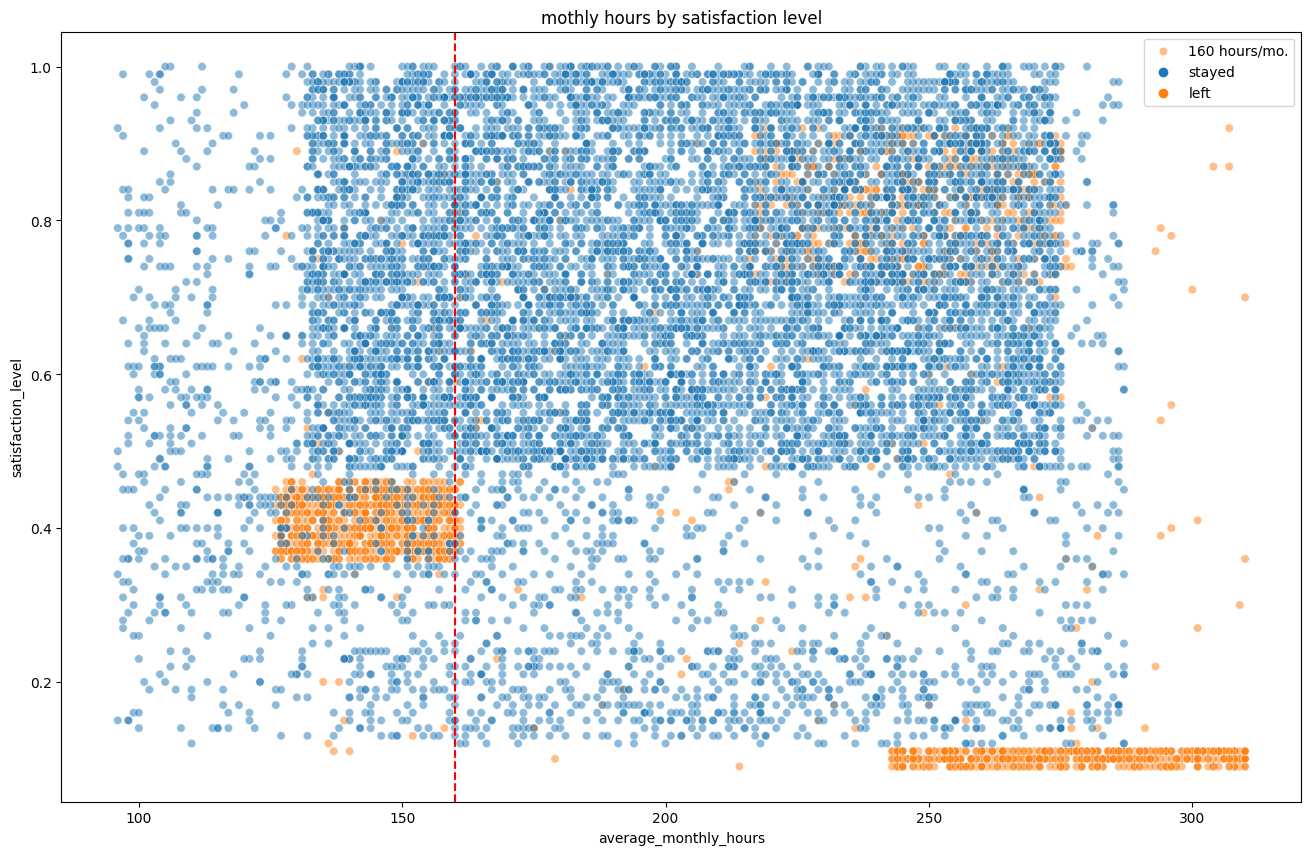

In [15]:
plt.figure(figsize=(16,10))
sns.scatterplot(data=df, x='average_monthly_hours', y='satisfaction_level', hue='left', alpha =0.5)
plt.axvline(x=160, color='r', label='160 hours/mo.', ls='--')
plt.legend(labels=['160 hours/mo.', 'stayed', 'left'])
plt.title('mothly hours by satisfaction level')

plt.show()

* data points are grouped in rectangles this could indicate that data is synthetic
* Also this plot shows us that a lot of left employees severly overworked and big group worked just a little bit less than average
* But most of left people have low satisfaction level

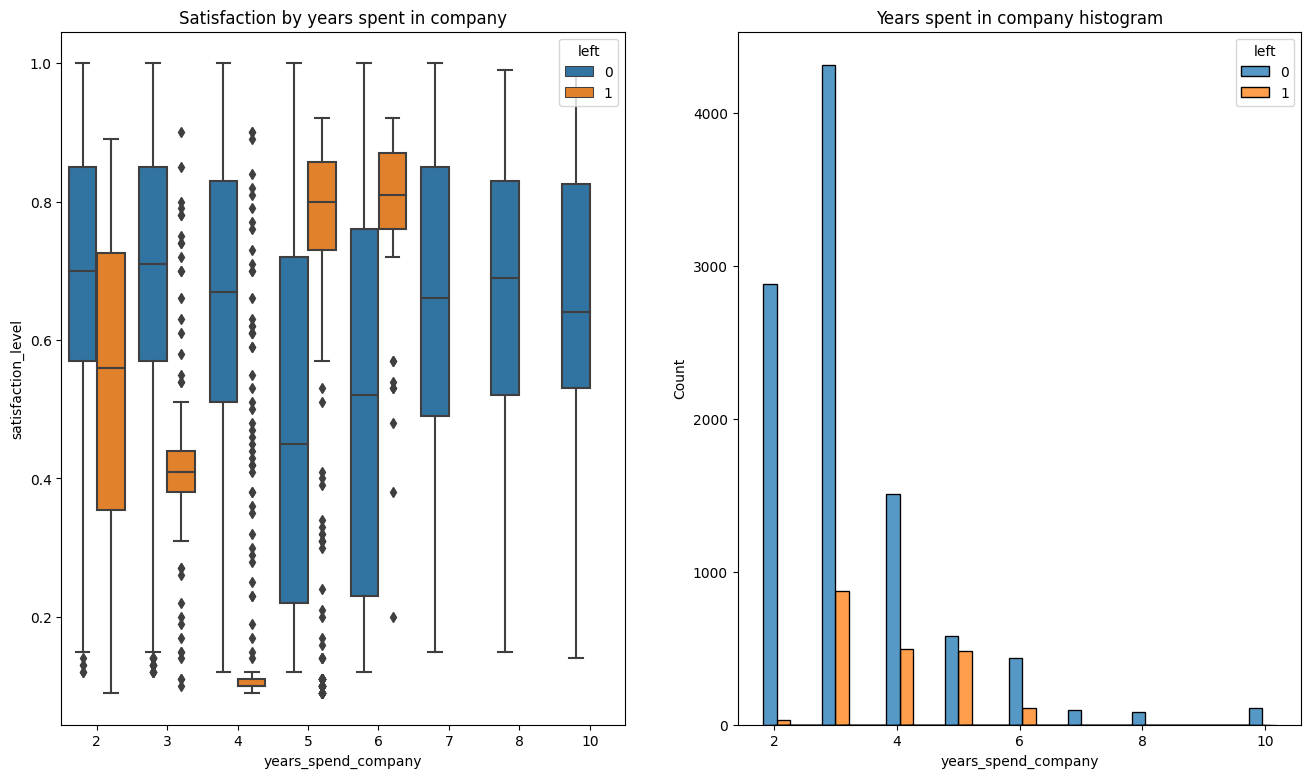

In [16]:
fig, ax = plt.subplots(1,2,figsize = (16,9))

sns.boxplot(data=df, x='years_spend_company', y='satisfaction_level', hue='left', ax=ax[0])
ax[0].set_title('Satisfaction by years spent in company')

sns.histplot(data=df, x='years_spend_company', hue='left', multiple='dodge', shrink=5, ax=ax[1])
ax[1].set_title('Years spent in company histogram')

plt.show()

* Employees who left fall into two general categories: dissatisfied employees with shorter years worked for company and very satisfied employees with medium-length years worked for company.
* Four-year employees who left seem to have an unusually low satisfaction level.
* The histogram shows that there are relatively few longer years_spend_company employees. It's possible that they're the higher-ranking, higher-paid employees.

In [17]:
df.groupby(['left'])['satisfaction_level'].agg([np.mean,np.median])

,mean,median
left,,
0,0.667365,0.69
1,0.440271,0.41


As expected, the mean and median satisfaction scores of employees who left are lower than those of employees who stayed.

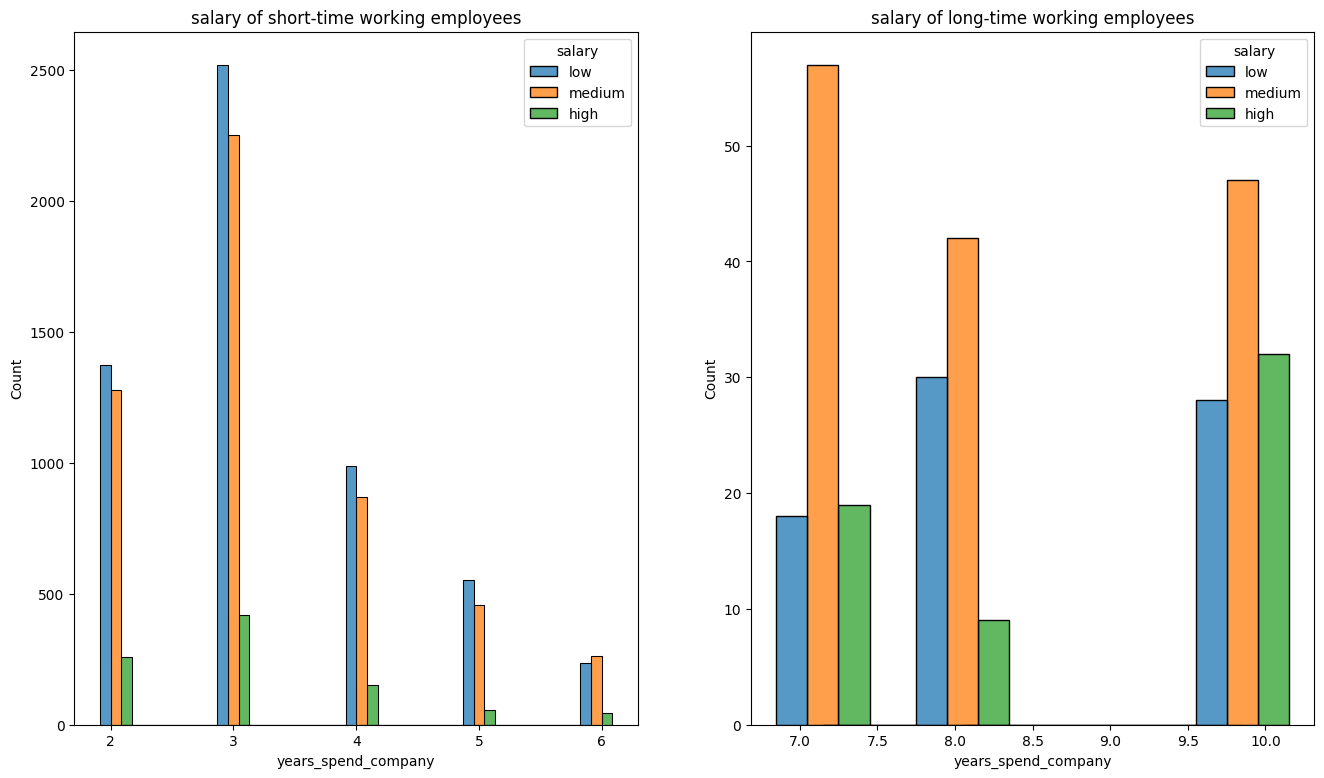

In [18]:
fig, ax = plt.subplots(1,2,figsize=(16,9))
#long and short time working employees
long_yrs_comp = df[df['years_spend_company'] > 6]
short_yrs_comp = df[df['years_spend_company'] <=6]
#plot short time working employees and their salaries
sns.histplot(data=short_yrs_comp, x='years_spend_company', hue='salary', hue_order=['low', 'medium', 'high'], multiple='dodge', shrink=3, ax=ax[0])
ax[0].set_title('salary of short-time working employees')

sns.histplot(data=long_yrs_comp, x='years_spend_company', hue='salary', hue_order=['low', 'medium', 'high'], multiple='dodge', shrink=2, ax=ax[1])
ax[1].set_title('salary of long-time working employees')

plt.show()

* Very strange observation occured, there is no one who worked for 9 years in this company. 
* And as we can see employees who spent more years for this company proportionally tend to have higher salaries

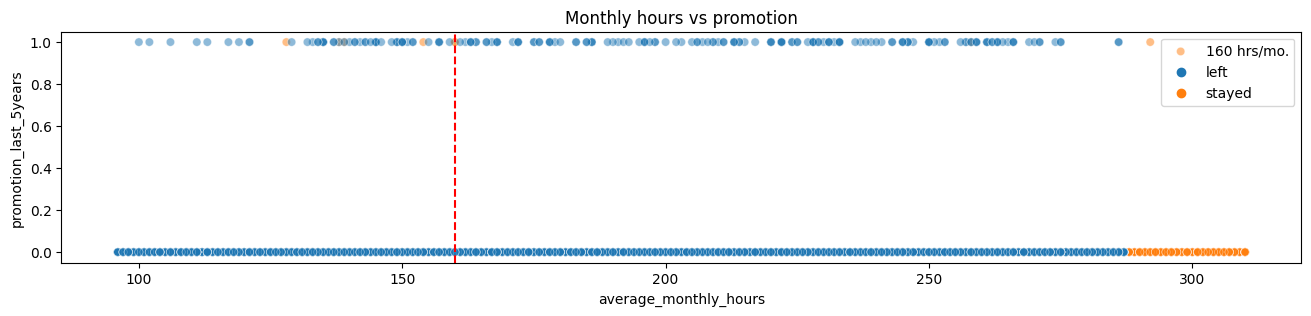

In [19]:
plt.figure(figsize=(16,3))

sns.scatterplot(data=df, x='average_monthly_hours', y='promotion_last_5years', hue='left', alpha=0.5)
plt.axvline(x=160, color='r', label='160 hrs/mo.', ls='--')
plt.legend(['160 hrs/mo.', 'left', 'stayed'])
plt.title('Monthly hours vs promotion')
plt.show()

* Very few people who were promoted left the company.
* And almost everyone who worked more than 280 hours and was not promoted left

<Axes: >

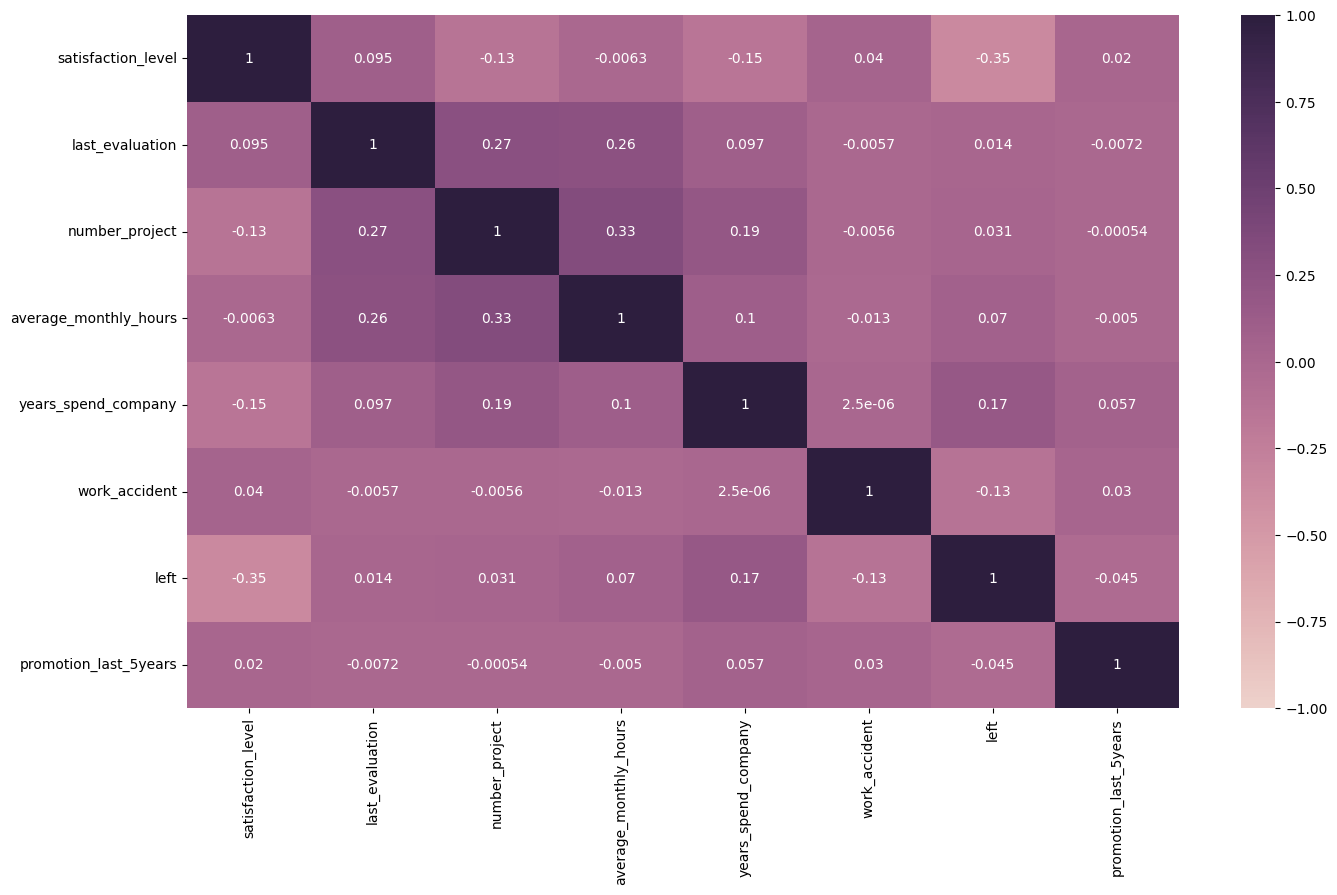

In [20]:
plt.figure(figsize=(16,9))

sns.heatmap(df.drop(columns=['department', 'salary']).corr(), vmin=-1, vmax=1, annot=True, cmap=sns.cubehelix_palette(as_cmap=True))

The correlation heatmap confirms that the number of projects, monthly hours, and evaluation scores all have some positive correlation with each other, and whether an employee leaves is negatively correlated with their satisfaction level.

Leaving is tied to longer working hours, many projects, and generally lower satisfaction levels. It can be ungratifying to work long hours and not receive promotions or good evaluation scores. There's a sizeable group of employees at this company who are probably burned out.

# Model Building

### Identify types of models
Since the variable we need to predict (whether an employees leaves the company) is categorical,
I choose to build 2 Tree-based machine learning models compare them and choose the best one.

## Modeling
Firstly i would like to make some new features that might help my model.

In [21]:
#feature engeneering
df['hard_worker'] = np.where(df['average_monthly_hours'] > 300, 1, 0)

df['load'] = df['average_monthly_hours']*df['last_evaluation']

df['hours_per_project'] = df['average_monthly_hours']/df['number_project']
df.head(5)

/tmp/ipykernel_20/3917097041.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hard_worker'] = np.where(df['average_monthly_hours'] > 300, 1, 0)
/tmp/ipykernel_20/3917097041.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['load'] = df['average_monthly_hours']*df['last_evaluation']
/tmp/ipykernel_20/3917097041.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,years_spend_company,work_accident,left,promotion_last_5years,department,salary,hard_worker,load,hours_per_project
0,0.38,0.53,2,157,3,0,1,0,sales,low,0,83.21,78.500000
1,0.80,0.86,5,262,6,0,1,0,sales,medium,0,225.32,52.400000
2,0.11,0.88,7,272,4,0,1,0,sales,medium,0,239.36,38.857143
3,0.72,0.87,5,223,5,0,1,0,sales,low,0,194.01,44.600000
4,0.37,0.52,2,159,3,0,1,0,sales,low,0,82.68,79.500000


We need to convert our categorical variablte to numeric, because model can only understand numeric ones

In [22]:
df['salary'].replace({'low':1,
                       'medium':2,
                       'high':3},
                     inplace=True)
df.head(5)

/tmp/ipykernel_20/774240741.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['salary'].replace({'low':1,


,satisfaction_level,last_evaluation,number_project,average_monthly_hours,years_spend_company,work_accident,left,promotion_last_5years,department,salary,hard_worker,load,hours_per_project
0,0.38,0.53,2,157,3,0,1,0,sales,1,0,83.21,78.500000
1,0.80,0.86,5,262,6,0,1,0,sales,2,0,225.32,52.400000
2,0.11,0.88,7,272,4,0,1,0,sales,2,0,239.36,38.857143
3,0.72,0.87,5,223,5,0,1,0,sales,1,0,194.01,44.600000
4,0.37,0.52,2,159,3,0,1,0,sales,1,0,82.68,79.500000


In [23]:
df=pd.get_dummies(df)
df.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,years_spend_company,work_accident,left,promotion_last_5years,salary,hard_worker,...,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,1,0,...,False,False,False,False,False,False,False,True,False,False
1,0.80,0.86,5,262,6,0,1,0,2,0,...,False,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,1,0,2,0,...,False,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,1,0,1,0,...,False,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,1,0,1,0,...,False,False,False,False,False,False,False,True,False,False


### Data split
Now we are ready to build a model but first we need to split our data into train/validation/test sets(60,20,20)

In [24]:
#Separate our X and y variables wich isolate features and target variables

y = df['left']

X = df.copy()
X = X.drop(columns=['left'])

#Split into train validation and test sets

X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, stratify=y_tr, random_state=42)

Verify the number of rows in each of the sets.

In [25]:
print('Train:', X_train.shape, y_train.shape)
print('test:', X_test.shape, y_test.shape)
print('validation:', X_val.shape, y_val.shape)

Train: (7194, 21) (7194,)
test: (2399, 21) (2399,)
validation: (2398, 21) (2398,)


## XGBClassifier
We begin with using GridSearchCV to tune the model

In [26]:
xgb = XGBClassifier(objective='binary:logistic',random_state=42)

cv_params = {'n_estimators': [150,300,500],
            'max_depth': [3,4,5],
            'min_child_weight': [0.5,1,1.5],
            'learning_rate':[0.05,0.1,0.2],
            }

#dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='recall')

Now we need to fit the model

In [27]:
%%time
xgb_cv.fit(X_train,y_train)

CPU times: user 27min 13s, sys: 13 s, total: 27min 26s
Wall time: 7min 3s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'min_child_weight': [0.5, 1, 1.5],
                         'n_estimators': [150, 300, 500]},
             refit='recall', scoring={'precision', 'f1', 'recall', 'accuracy'})

Examine our best average score

In [28]:
xgb_cv.best_score_

0.9188284518828451

The best combination of hyperparameters

In [29]:
xgb_cv.best_params_

{'learning_rate': 0.2,
 'max_depth': 3,
 'min_child_weight': 0.5,
 'n_estimators': 300}

Could be useful to try different hyperparameters to tune model but for now i would leave it like this

In [30]:
def make_results(model_name:str, model_object, metric:str):
    '''
    model_name: is the name that you want to give to your model in the output table
    model_object: a fit GridSearchCV object
    metric: could be precision, recall, accuracy or f1
    
    returns pandas DataFrame with the precision, recall, accuracy and f1 scores 
    for the model with the best 'metric' score across all validation folds
    '''
    metric_dict = {'precision':'mean_test_precision',
                  'recall':'mean_test_recall',
                  'f1':'mean_test_f1',
                  'accuracy':'mean_test_accuracy'}
    # we need to get all the results from the CV
    cv_results = pd.DataFrame(model_object.cv_results_)
    
    #now we need to isolate row with the best mean metric score
    best_result = cv_results.loc[cv_results[metric_dict[metric]].idxmax(),:]
    
    precision = best_result.mean_test_precision
    recall = best_result.mean_test_recall
    f1 = best_result.mean_test_f1
    accuracy = best_result.mean_test_accuracy
    
    table = pd.DataFrame({'model_name':[model_name],
                         'precision':[precision],
                         'recall':[recall],
                         'f1':[f1],
                         'accuracy':[accuracy]},)
    return table

In [31]:
results = make_results('XGBClassifier', xgb_cv, 'recall')
results

,model_name,precision,recall,f1,accuracy
0,XGBClassifier,0.970323,0.918828,0.943496,0.98179


All of the scores are pretty high, i guess it would be helpfull to spend more time tunning the model to make recall score even higher

## Random Forest
We begin with using GridSearchCV to tune the model

In [32]:
rf = RandomForestClassifier(random_state=42)

cv_params_rf = {'max_depth': [3,5,None],
             'max_features': ["sqrt"],
             'max_samples': [0.8, 0.9],
             'min_samples_leaf': [1,2,4],
             'min_samples_split': [3,4,6],
             'n_estimators': [50,75,100],
             }

scoring = {'accuracy', 'precision', 'recall', 'f1'}

rf_cv = GridSearchCV(rf, cv_params_rf, scoring=scoring, cv=5, refit='recall')

In [33]:
%%time
rf_cv.fit(X_train,y_train)

CPU times: user 5min 55s, sys: 1.39 s, total: 5min 56s
Wall time: 5min 56s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [3, 5, None], 'max_features': ['sqrt'],
                         'max_samples': [0.8, 0.9],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [3, 4, 6],
                         'n_estimators': [50, 75, 100]},
             refit='recall', scoring={'precision', 'f1', 'recall', 'accuracy'})

In [34]:
rf_cv.best_score_

0.9062761506276151

In [35]:
rf_cv.best_params_

{'max_depth': None,
 'max_features': 'sqrt',
 'max_samples': 0.9,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 100}

In [36]:
rf_res = make_results('RandomForest', rf_cv, 'recall')
results = pd.concat([results, rf_res])
results

,model_name,precision,recall,f1,accuracy
0,XGBClassifier,0.970323,0.918828,0.943496,0.981790
0,RandomForest,0.986571,0.906276,0.944444,0.982346


Comparing to models we can see that XGBoost model performs a bit better on training data, now let's compare them on validation dataset

In [37]:
xgb_y_pred = xgb_cv.best_estimator_.predict(X_val)

In [38]:
def get_test_score(model_name:str, preds, y_test_data):
    
    
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)
    accuracy = accuracy_score(y_test_data, preds)
    
    table = pd.DataFrame({'model_name':[model_name],
                         'precision':[precision],
                         'recall':[recall],
                         'f1':[f1],
                         'accuracy':[accuracy]},)
    return table

In [39]:
xgb_val_scores = get_test_score('XGB_val', xgb_y_pred, y_val)

results = pd.concat([results, xgb_val_scores])

In [40]:
rf_y_preds = rf_cv.best_estimator_.predict(X_val)

rf_val_scores = get_test_score('RF_val', rf_y_preds, y_val)
results = pd.concat([results, rf_val_scores])
results

,model_name,precision,recall,f1,accuracy
0,XGBClassifier,0.970323,0.918828,0.943496,0.981790
0,RandomForest,0.986571,0.906276,0.944444,0.982346
0,XGB_val,0.978723,0.924623,0.950904,0.984153
0,RF_val,0.981183,0.917085,0.948052,0.983319


XGB model made even better prediction on validation dataset
Now let's fit our best model with test data

In [41]:
y_pred = xgb_cv.best_estimator_.predict(X_test)

xgb_final_score = get_test_score('XGB_best', y_pred, y_test)

results = pd.concat([results,xgb_final_score])
results

,model_name,precision,recall,f1,accuracy
0,XGBClassifier,0.970323,0.918828,0.943496,0.981790
0,RandomForest,0.986571,0.906276,0.944444,0.982346
0,XGB_val,0.978723,0.924623,0.950904,0.984153
0,RF_val,0.981183,0.917085,0.948052,0.983319
0,XGB_best,0.951282,0.932161,0.941624,0.980825


## Construct confusion matrix

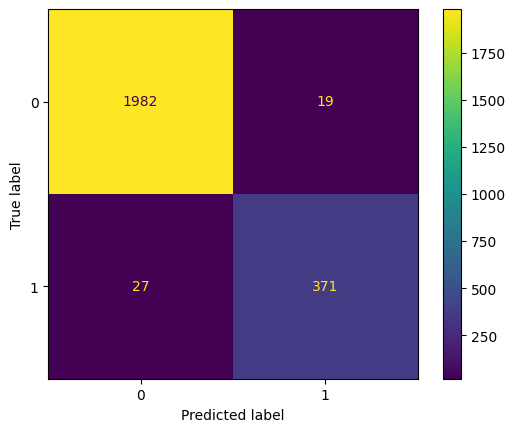

In [42]:
cm = confusion_matrix(y_test,y_pred)

disp = ConfusionMatrixDisplay(cm, display_labels=xgb_cv.classes_)
disp.plot()

Model predicts more False Negatives, that means that some employees may be identified as not at risk of leaving when in fact they will leave. But this is still a strong model

## Feature importance
we'll use plot_importance function to inspect the most important features of our final model

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

<Figure size 1600x900 with 0 Axes>

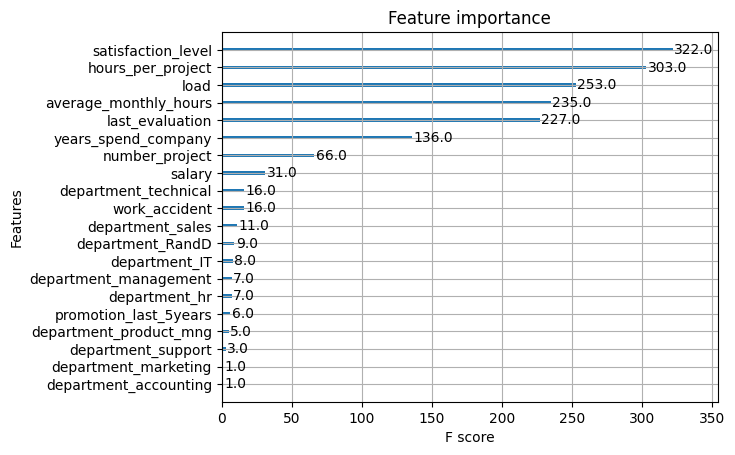

In [43]:
plt.figure(figsize=(16,9))
plot_importance(xgb_cv.best_estimator_)

As we can see the most importans feature is satisfaction level as expected. But promotion in the last 5 years is not important feature but i thought it has high value on either employee leave or no. XGBoost model couldn't make more use of the department feature.

## Summary of model results


In [44]:
print(results)

      model_name  precision    recall        f1  accuracy
0  XGBClassifier   0.970323  0.918828  0.943496  0.981790
0   RandomForest   0.986571  0.906276  0.944444  0.982346
0        XGB_val   0.978723  0.924623  0.950904  0.984153
0         RF_val   0.981183  0.917085  0.948052  0.983319
0       XGB_best   0.951282  0.932161  0.941624  0.980825


After conducting feature engineering and modeling two different models we have our champion model - XGB
that achived precision-score of 95.1%, recall-score of 93.2%, f1-score of 94,2% and accuracy-score of 98%

## Conclusion, Recommendations
The models and the feature importance extracted from the models confirm that employees at the company overwork a lot.

To retain employees company could change their working politics such as:
* Cap number of project that employee can work on
* Reward employees that overwork or create enviroment so that they couldn't overwork.
* Consider promoting employees who have been working for the company at least four years, or investigate why their satisfaction level is so low.